<a href="https://colab.research.google.com/github/Juanba98/AdversarialPatch/blob/main/AdversarialPatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch torchvision  --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116


# Adversarial Patch attack (https://arxiv.org/abs/1712.09665).

We replace a part of a image with a patch. This patch must be masked to allow it to take any shape (in this aproach just a circle), then train this patch over a data set of images, applying a random translation, scaling and rotation on it for every image, and optimizing using gradient descent.

Given a image $x \in \mathbb{R}^{w \times h \times c}$, patch $p$, patch location $l$, and patch trasnformation $t$, we define a *patch aplication operator*

$$A(p,x,l,t)$$

That apply the transformation $t$ to the patch $p$, and then applies the transformed partch $p$ to the image $x$ at location $l$

To obtain the trained patch $\hat{p}$ (Variant of Expectation over Transformation (EOT))

$$\hat{p} = arg \max_{p} \mathbb{E}_{x \sim X,t\sim T,l\sim L} [logPr(\hat{y}|A(p,x,l,t))]$$

* $X$ is a training set of images
* $T$ is a distribution over transformations of the patch
* $L$ is a distribution over locations in the image 



##Referential implementation:
- https://github.com/cleverhans-lab/cleverhans/blob/master/cleverhans_v3.1.0/examples/adversarial_patch/AdversarialPatch.ipynb
- https://github.com/jhayes14/adversarial-patch
- https://github.com/A-LinCui/Adversarial_Patch_Attack

# Imports

In [2]:
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision as TV
from torch import nn
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.interpolation import rotate

#PATHS
from importlib.machinery import SourceFileLoader
from os.path import join
paths = SourceFileLoader('paths', '/content/paths.py').load_module()


# Device to use


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


#Utils

In [4]:
def show(imgs, gray = False):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transforms.functional.to_pil_image(img)
        if(gray):
            axs[0, i].imshow(np.asarray(img),cmap="gray")
        else:
          axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


def unNormalize (mean, std):

  invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0. for x in mean],
                                                std = [ 1/x for x in std]),
                          transforms.Normalize(mean = [ -x for x in mean],
                                                std = [ 1. for x in std]),
                          ])

  return invTrans

#Adversarial Patch

In [5]:

class AdversarialPatch(object):

  def __init__(self, model_name, patch_shape, target_label_idx, image_shape, max_rotation, save_path, mean, std):
    
    self.model_name = model_name #CIFAR10 or MNIST
    self.patch_shape = patch_shape # patch shape (B x C x H x W)
    self.patch = self.create_circular_mask(self.patch_shape) # initial patch
    self.target_label_idx = target_label_idx # index of the target label
    self.image_shape = image_shape #image shape (C x H x W)
    self.max_rotation = max_rotation #max rotation for the patch transform
    self.save_path = save_path #path for save the results ('' to no save)
    self.result_list = [] #list to storage the results images
    self.mean = mean #mean of the normalize transform of the data set
    self.std = std #std of the normalize transform of the data set


  def train(self, train_loader, model, epoch):

    '''
    :param train_loader: mask for the patch (B x C x H x W)
    :type train_loader: torch.FloatTensor
    :param model: Model to attack
    :type model: nn.Module
    :param epoch: Current epoch
    :type epoch: int
    :return: patch Adversarial Patch, adv_x Adversarial Example and correct 
    '''

    model.eval()
    correct = 0
    total = 0
    
    for i, (images, labels) in enumerate(train_loader):

      images, labels = images.to(device),  labels.to(device)
      
      #get the image prediction
      prediction = model(images)
      
      # only computer adversarial examples on examples that are originally classified correctly
      # and are not the same class as the target        
      if prediction.data.max(1)[1][0] != labels.data[0] or self.target_label_idx == labels.data[0]:
          continue
        
      #apply random tranformation to the patch
      mask, x_location, y_location = self.circle_transform(images.shape, self.image_shape[0])

      self.patch, mask = torch.FloatTensor(self.patch), torch.FloatTensor(mask)
      
      self.patch, mask = self.patch.to(device), mask.to(device)


      #run the attack
      adv_x, mask = self.attack(model, images, mask)
      
      adv_label = model(adv_x).data.max(1)[1][0]
      ori_label = labels.data[0]

      #if the target label and the adversarial are the same
      if adv_label == self.target_label_idx:
    
        correct += 1

        #Revert the Normalize of the data set
        invTrans = self._unNormalize(self.mean, self.std)
        
        
        aux1 = invTrans(images[0])
        aux2 = invTrans(adv_x[0])
      
          
        #add the original image and the adversarial one to the result list
        self.result_list.append([aux1,aux2])
       
        #Save the images
        if(self.save_path!=''):

          # plot source image
          TV.utils.save_image(aux1, join(self.save_path, '%d_%s_original.png'%(epoch,  ori_label.item())))
  

          # plot adversarial image
          TV.utils.save_image(aux2, join(self.save_path, '%d_%s_%s_adversarial.png' %(epoch, ori_label.item(), adv_label.item()))) 
        
  

      #apply the mask to the patch
      masked_patch = torch.mul(mask, self.patch)
      
      

      self.patch = masked_patch.data.cpu().numpy()
      new_patch = np.zeros(self.patch_shape)

      #extract the patch
      new_patch = self.patch[:, : , x_location:x_location + self.patch_shape[-1], y_location:y_location + self.patch_shape[-1]]

    

      self.patch = new_patch


      return self.patch, adv_x, correct

  def attack(self, model, image, mask):
    '''
    :param model: Model to attack
    :type model: nn.Module
    :param image: image to attack (B x C x H x W)
    :type image: torch.FloatTensor
    :param mask: mask for the patch (B x C x H x W)
    :type mask: torch.FloatTensor 
    :return: adv_x attacked image (image with patch over it), mask
    '''
    
    model.eval()

    output = model(image)
    x_out = F.softmax(output,dim=1)#probabilities prediction for the image


    target_prob = x_out.data[0][self.target_label_idx]
    
    #apply the patch to the image using the mask
    adv_x = torch.mul((1-mask), image) + torch.mul(mask,self.patch)
  
    count = 0
    Loss = 0 
  
    #dont stop until we reach 90% of confident
    while 0.9 > target_prob:
        
        count += 1

        adv_x = torch.tensor(adv_x.data, requires_grad=True)

        adv_out = F.log_softmax(model(adv_x))#probabilities prediction for the adversarial image
      
        
        adv_out_probs, adv_out_labels = adv_out.max(1)
        
        Loss = -adv_out[0][self.target_label_idx]
        Loss.backward()
    
        adv_grad = adv_x.grad.clone()
        
        adv_x.grad.data.zero_()

        #apply the perturbation to the patch
        self.patch -= adv_grad 
        
        
        #apply the patch with updated perturbation to the image using the mask
        adv_x = torch.mul((1-mask),image) + torch.mul(mask,self.patch)

        #imshow2(adv_x[0].cpu())
        adv_x = torch.clamp(adv_x, -1, 1)

        out = F.softmax(model(adv_x))#probabilities prediction for the new adversarial image
        target_prob = out.data[0][self.target_label_idx] #get target probability
        

        if count >= 1000:
          Loss = -1
          break

    print(f'Loss {Loss}')
    return adv_x, mask


  

  def circle_mask(self, shape, sharpness = 40):
    '''
    :param shape: shape of the circle,  (H x W x C)
    :type shape: Tuple
    :param sharpness: to improve the circle shape
    :return: circle mask (H x W x C)
    '''
    diameter = shape[0]  
    x = np.linspace(-1, 1, diameter)
    y = np.linspace(-1, 1, diameter)
    xx, yy = np.meshgrid(x, y, sparse=True)
    z = (xx**2 + yy**2) ** sharpness

    mask = 1 - np.clip(z, -1, 1)
    mask = np.expand_dims(mask, axis=2)
    mask = np.broadcast_to(mask, shape).astype(np.float32)
  

    return mask



  def create_circular_mask(self, patch_shape):
    '''
    :param patch_shape: shape of the circle,  (B x C x H x W)
    :type patch_shape: Tuple
    :return: circle mask (B x C x H x W)
    '''

    mask  = self.circle_mask( (patch_shape[-1], patch_shape[-1], patch_shape[1]) )
    
    mask = mask[: , :, :, np.newaxis].transpose(3,2,1,0) 

    return mask
    


  def circle_transform(self, data_shape, image_size):
    '''
    Variant of the Expectiation over Transformation (EOT)
    We apply the rotation and change the patch location

    :param data_shape: shape of the images of the dataset,  (B x C x H x W)
    :type patch: torch.Size
    :param image_size: size of image
    :type image_size: int
    :return: y the new mask, x_location shift at x axis, y_location shift at y axis
    '''

    # get dummy image 
    x = np.zeros(data_shape)
    y = np.zeros(data_shape)

    # get shape
    m_size = self.patch_shape[-1]

    mask = self.create_circular_mask(self.patch.shape) 
    
    #Random shifting
    x_location, y_location = np.random.randint(low=0, high=image_size-self.patch_shape[-1]), np.random.randint(low=0, high=image_size-self.patch_shape[-1])

    #for each channel
    for i in range(x.shape[0]):

      # random rotation
      rot = np.random.uniform(-self.max_rotation, self.max_rotation)

      for j in range(self.patch[i].shape[0]):
      
        self.patch[i][j] = rotate(self.patch[i][j], angle=rot, reshape=False)
        


      # apply the random location to the patch and the mask  
      x[i, : , x_location:x_location + self.patch.shape[-1], y_location:y_location + self.patch.shape[-1]] = self.patch
      y[i, : , x_location:x_location + self.patch.shape[-1], y_location:y_location + self.patch.shape[-1]] = mask
    
      self.patch = x
      
    
    return y, x_location, y_location

  def _unNormalize(self, mean, std):
    return unNormalize(mean, std)

# CifarCNN

## Load Data

In [6]:
MEAN = [0.5,0.5,0.5]
STD =  [0.5,0.5,0.5]


batch_size = 4

dataloader = torch.utils.data.DataLoader(datasets.CIFAR10(root = '/content/CIFAR10', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(mean = MEAN, std = STD),
                           ])),  shuffle=True, batch_size = batch_size, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')




Files already downloaded and verified


## Neural Network

In [7]:
class CifarCNN(nn.Module):

  def __init__(self):
    super(CifarCNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
    self.bn1 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
    self.bn4 = nn.BatchNorm2d(128)
    self.fc5 = nn.Linear(512, 256)
    self.fc6 = nn.Linear(256, 256)
    self.fc7 = nn.Linear(256, 10)

  def forward(self, x):
    h = F.relu(self.bn1(self.conv1(x)))
    h = F.relu(self.bn2(self.conv2(h)))
    h = F.max_pool2d(h, 4)

    h = F.relu(self.bn3(self.conv3(h)))
    h = F.relu(self.bn4(self.conv4(h)))
    h = F.max_pool2d(h, 4)

    h = F.relu(self.fc5(h.view(h.size(0), -1)))
    h = F.relu(self.fc6(h))
    h = self.fc7(h)
    return F.log_softmax(h)

model = CifarCNN()

## Training

In [8]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1,  2000] loss: 1.779
[1,  4000] loss: 1.410
[1,  6000] loss: 1.237
[1,  8000] loss: 1.167
[1, 10000] loss: 1.081
[1, 12000] loss: 1.002
[2,  2000] loss: 0.924
[2,  4000] loss: 0.896
[2,  6000] loss: 0.874
[2,  8000] loss: 0.837
[2, 10000] loss: 0.829
[2, 12000] loss: 0.824
Finished Training


In [9]:
PATH = paths.CIFAR10_DIR
torch.save(model.state_dict(), PATH)

## Attack

In [10]:
#One image 
batch_size = 1
dataloader = torch.utils.data.DataLoader(datasets.CIFAR10(root = '/content/CIFAR10', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(mean = MEAN, std = STD),
                           ])),  shuffle=True, batch_size = batch_size, num_workers = 2)


Files already downloaded and verified


### Hyperparameters

In [11]:
PATH = paths.CIFAR10_DIR
SAVE_PATH = paths.CIFAR10_ADP_LOGS
MODEL_NAME = 'CIFAR10'

EPOCHS = 200
MAX_ROTATION = 22.5

TARGET_LABEL_IDX = 9

IMAGE_SHAPE = (32,32,3)

PATCH_SHAPE= (1, 3, 16, 16)

###Run Attack

In [12]:

model.load_state_dict(torch.load(PATH))

model.to(device)

adversary = AdversarialPatch(MODEL_NAME, PATCH_SHAPE, TARGET_LABEL_IDX, IMAGE_SHAPE, MAX_ROTATION, SAVE_PATH, MEAN, STD)
total_correct = 0
for epoch in range(1, EPOCHS+1):
  print('-'*20)
  print(f'Epoch:{epoch}')

  patch, adv, correct = adversary.train(dataloader, model, epoch)
  total_correct += correct

  inv_Trans= unNormalize(MEAN,STD)
  
  inv = torch.clamp(torch.from_numpy(patch[0]), -1, 1)
  inv = inv_Trans(inv)

  if(SAVE_PATH!=''):

    TV.utils.save_image(inv, join(SAVE_PATH, 'patch%d.png'%(epoch)))


  if (correct!=0):

    adversary.result_list[epoch-1].append(inv)
    

  else:
    
    adversary.result_list.append([])


  print("Patch attack success rate on trainset: {:.3f}%".format( 100 * total_correct/epoch))
  

 

#Scale patch shape to get more results

--------------------
Epoch:1
Loss 0.11260945349931717
Patch attack success rate on trainset: 100.000%
--------------------
Epoch:2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss 0.4469427168369293
Patch attack success rate on trainset: 100.000%
--------------------
Epoch:3
Loss 1.4696089029312134
Patch attack success rate on trainset: 100.000%
--------------------
Epoch:4
Loss 0.13436535000801086
Patch attack success rate on trainset: 100.000%
--------------------
Epoch:5
Loss 0.13855323195457458
Patch attack success rate on trainset: 100.000%
--------------------
Epoch:6
Loss 0.11223796755075455
Patch attack success rate on trainset: 100.000%
--------------------
Epoch:7
Loss 0.13006585836410522
Patch attack success rate on trainset: 100.000%
--------------------
Epoch:8
Loss 0.10740649700164795
Patch attack success rate on trainset: 100.000%
--------------------
Epoch:9
Loss 0.6333454251289368
Patch attack success rate on trainset: 100.000%
--------------------
Epoch:10
Loss 0.145146444439888
Patch attack success rate on trainset: 100.000%
--------------------
Epoch:11
Loss 0.0609322190284729
Patch attack success rate on trainset: 100.000%
-------------

## Display Results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


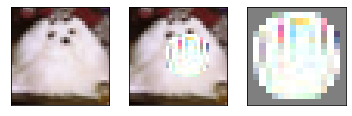

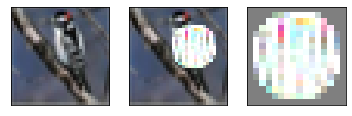

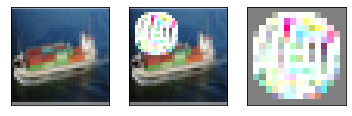

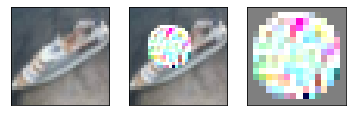

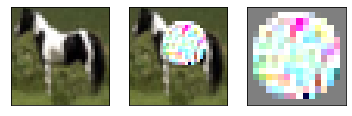

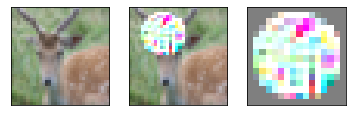

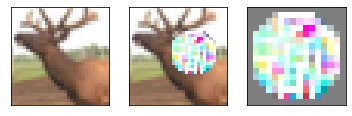

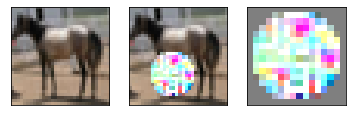

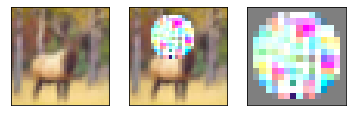

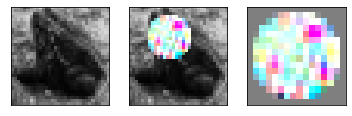

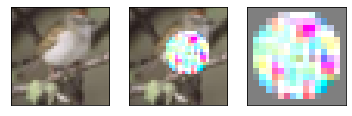

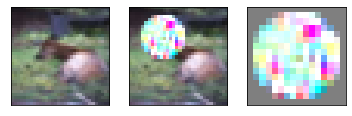

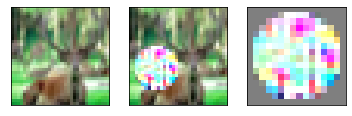

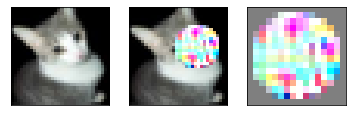

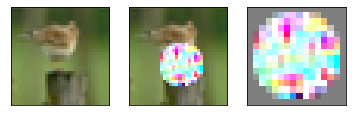

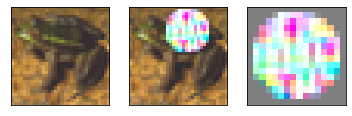

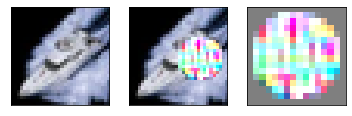

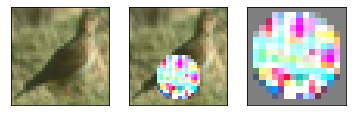

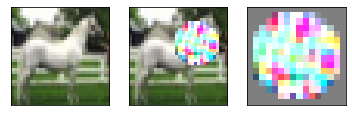

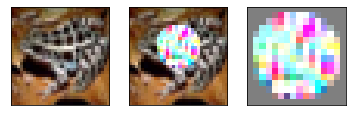

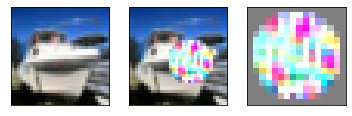

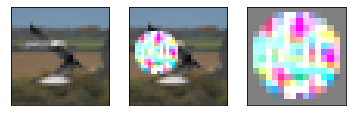

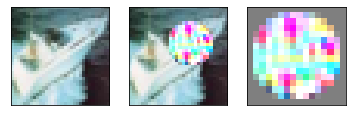

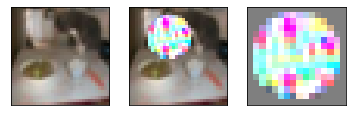

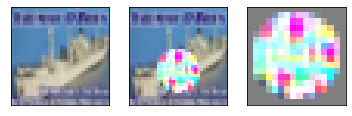

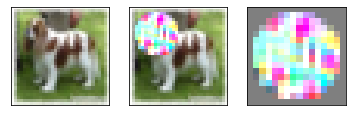

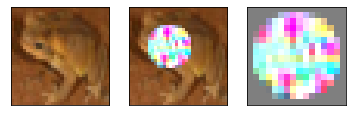

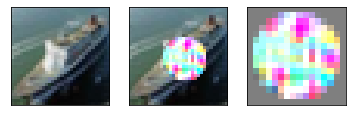

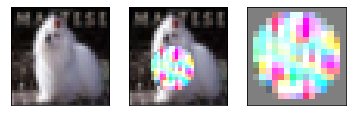

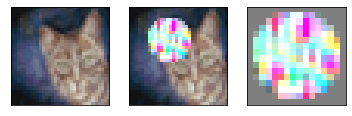

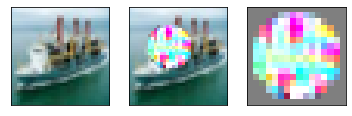

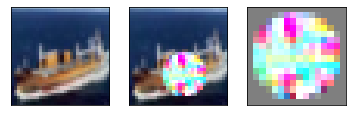

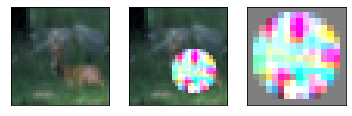

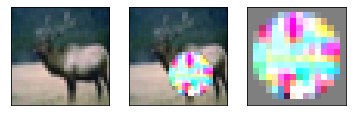

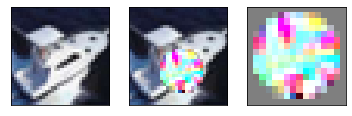

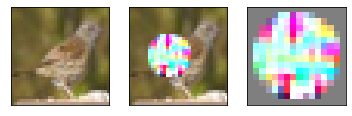

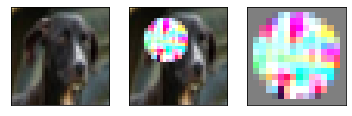

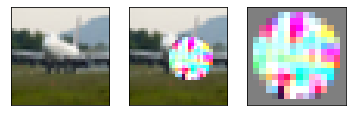

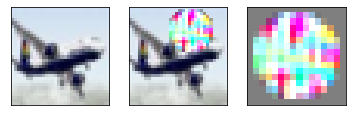

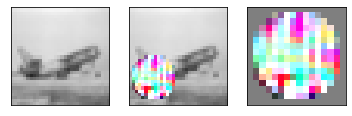

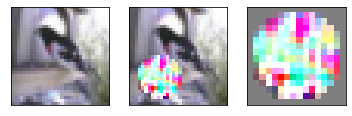

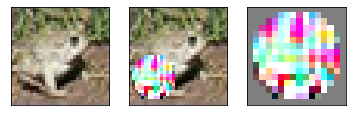

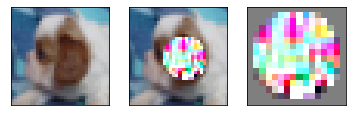

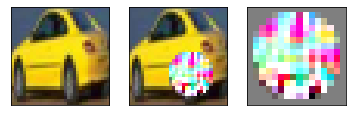

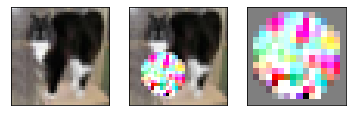

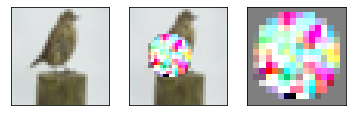

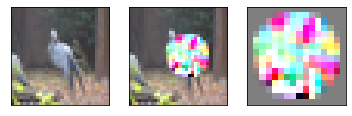

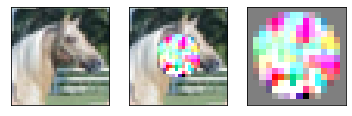

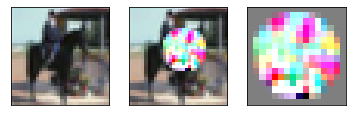

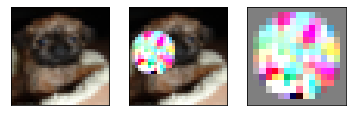

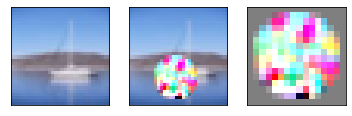

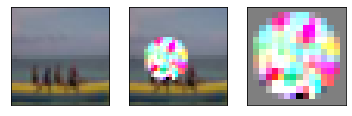

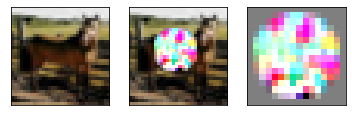

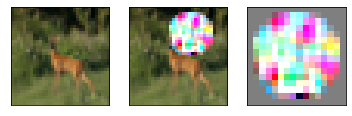

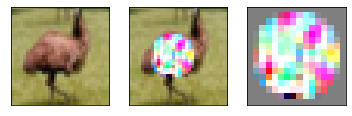

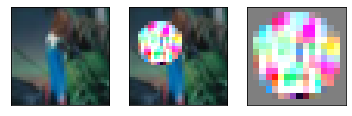

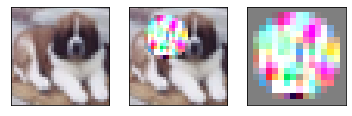

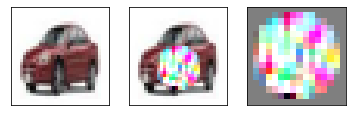

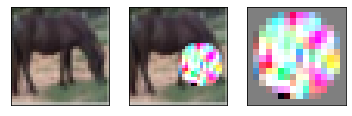

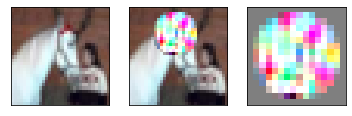

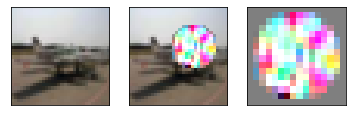

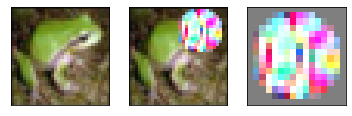

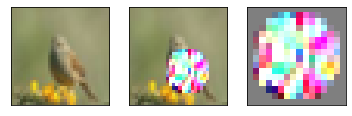

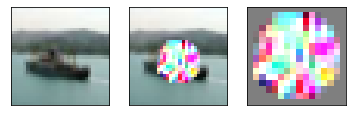

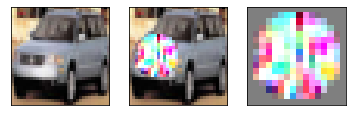

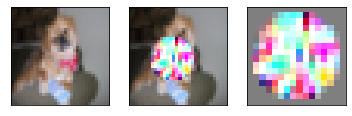

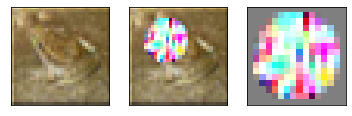

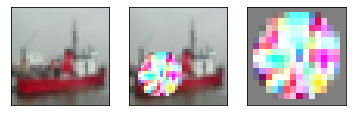

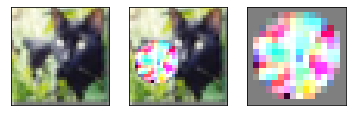

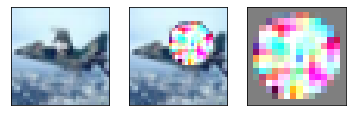

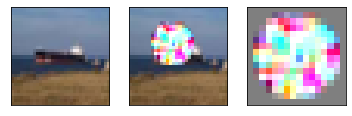

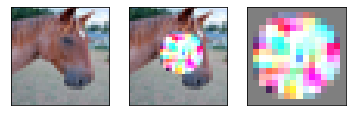

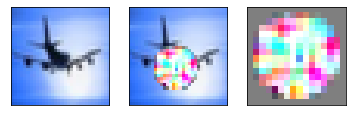

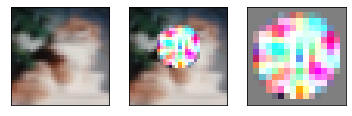

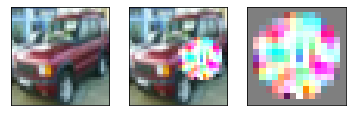

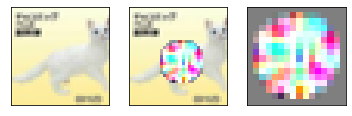

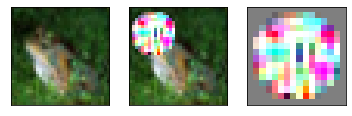

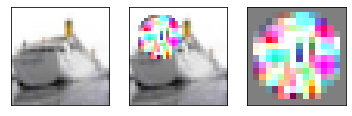

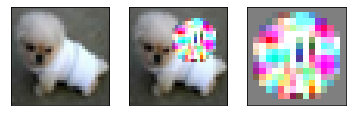

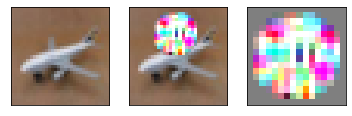

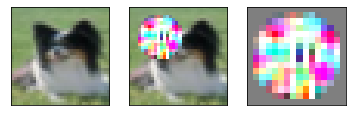

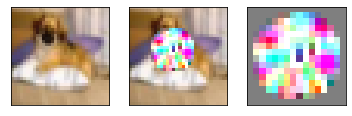

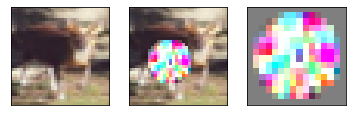

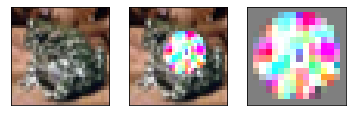

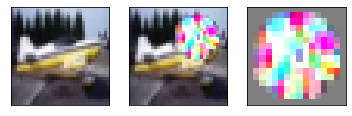

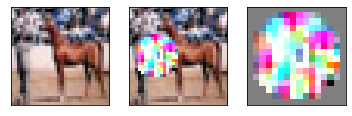

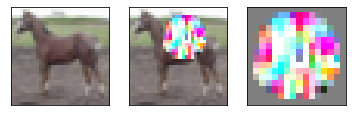

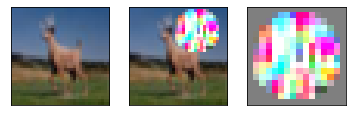

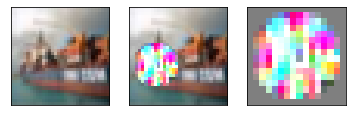

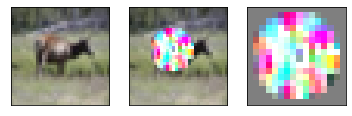

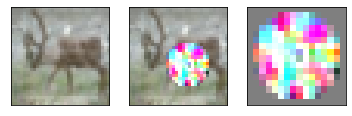

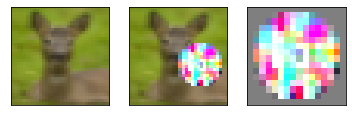

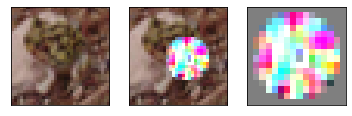

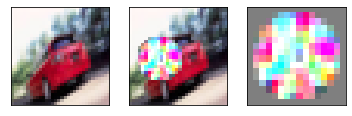

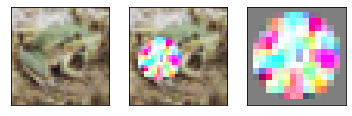

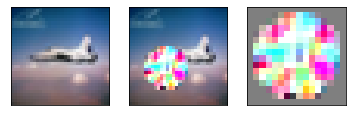

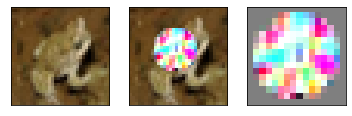

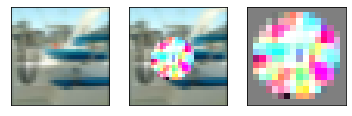

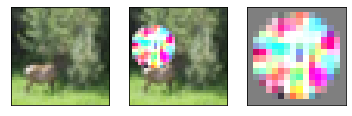

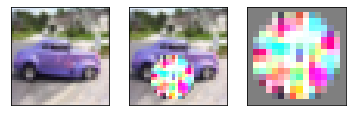

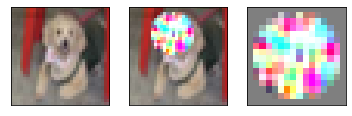

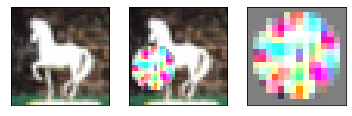

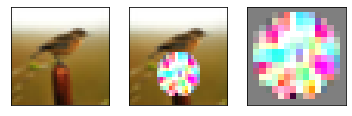

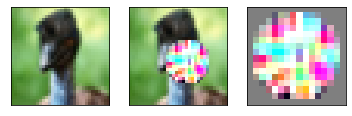

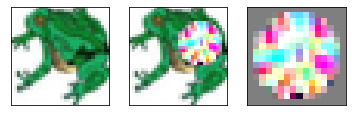

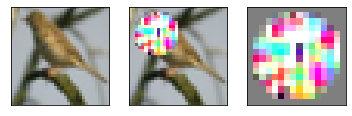

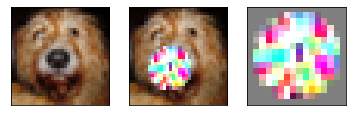

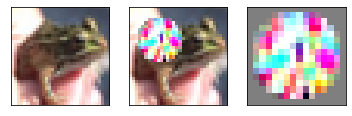

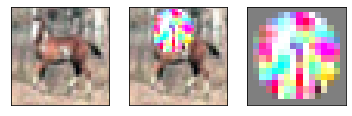

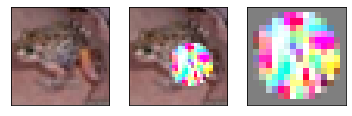

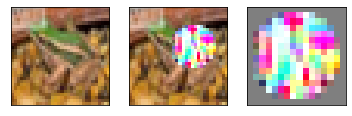

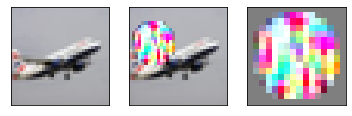

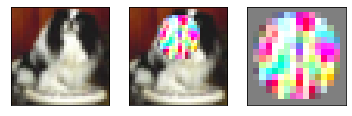

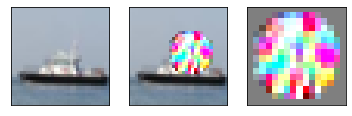

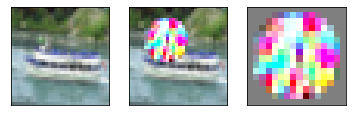

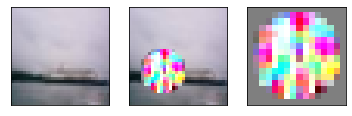

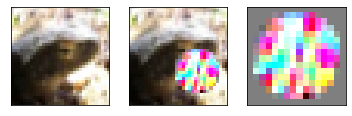

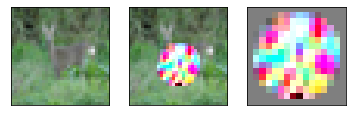

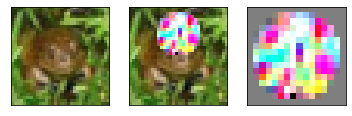

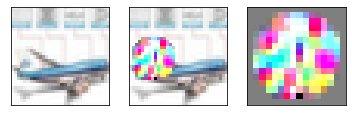

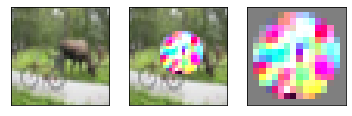

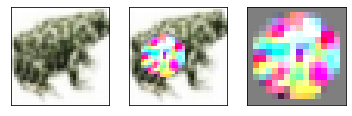

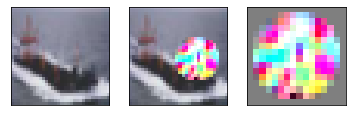

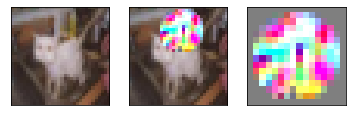

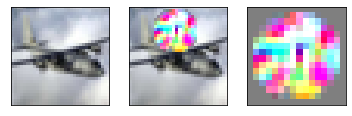

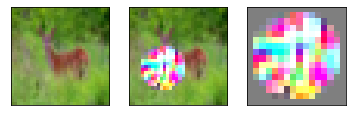

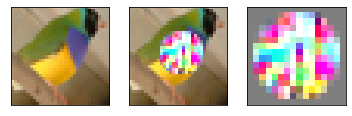

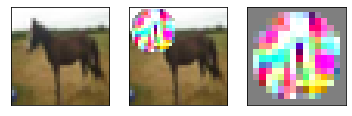

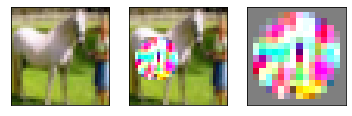

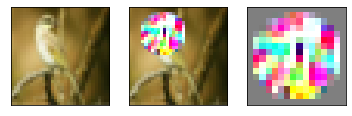

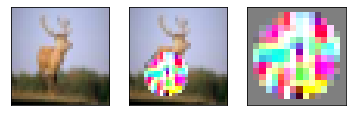

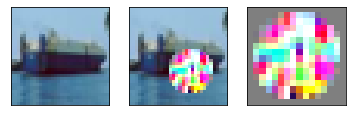

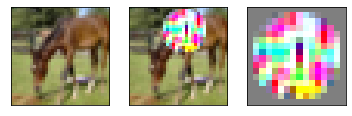

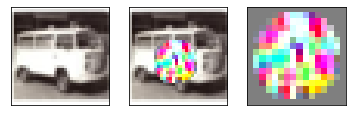

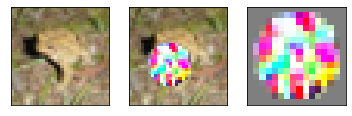

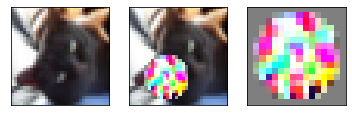

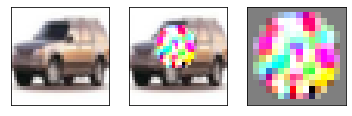

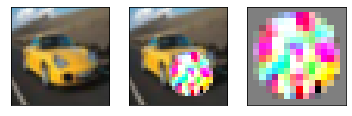

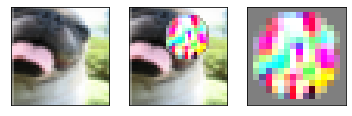

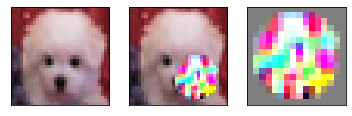

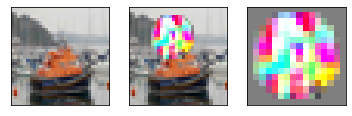

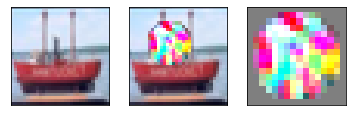

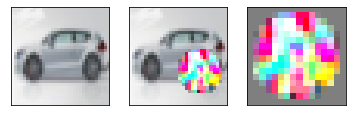

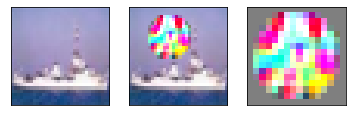

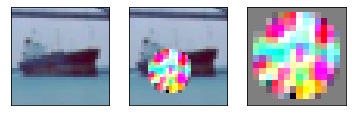

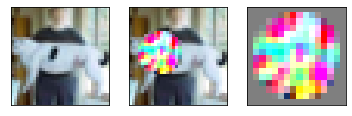

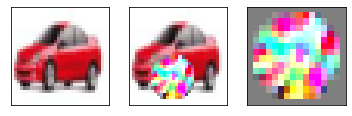

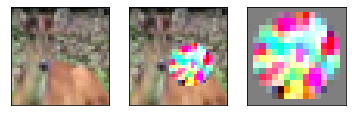

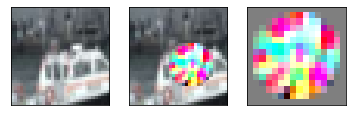

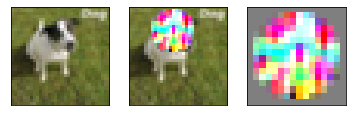

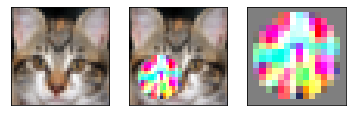

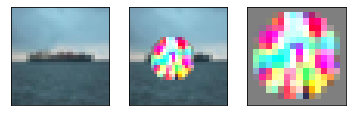

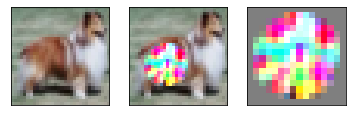

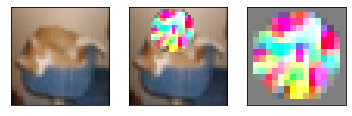

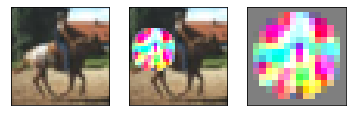

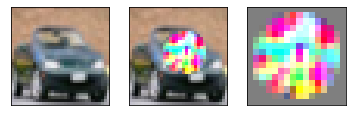

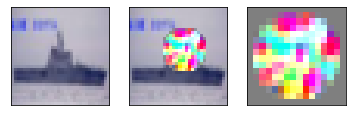

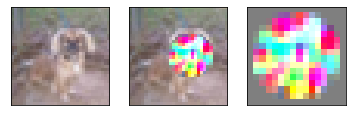

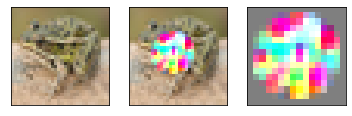

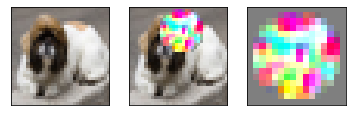

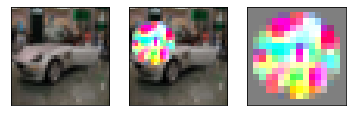

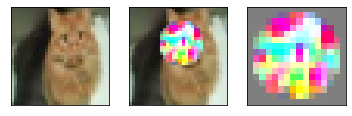

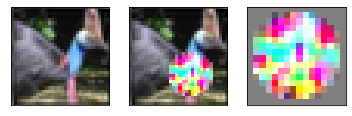

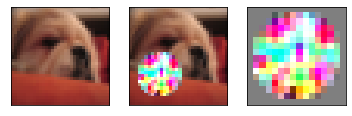

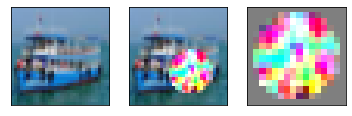

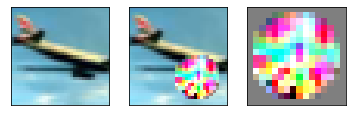

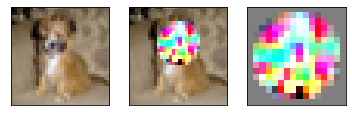

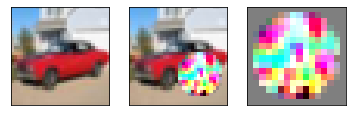

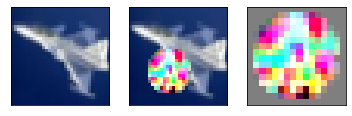

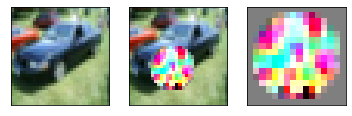

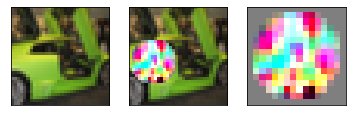

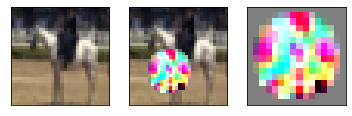

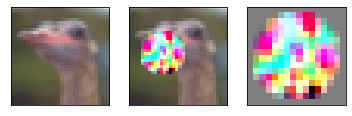

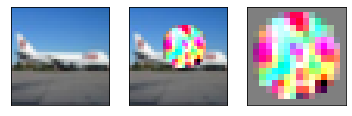

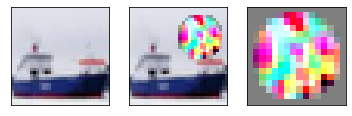

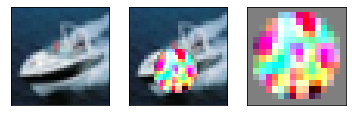

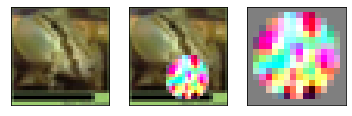

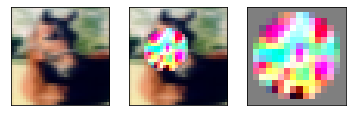

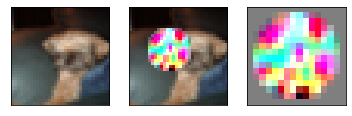

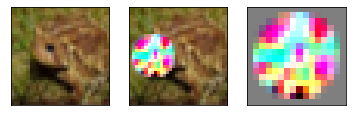

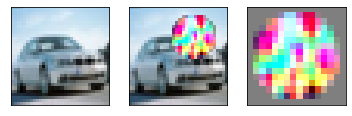

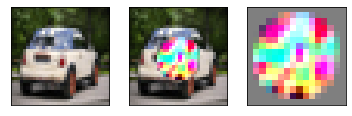

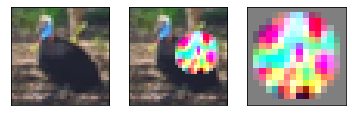

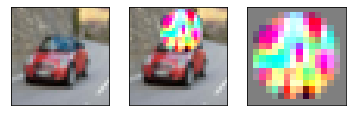

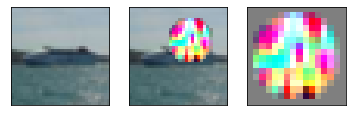

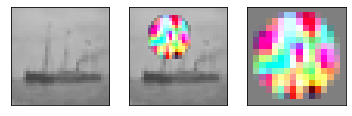

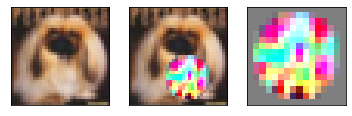

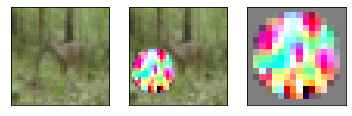

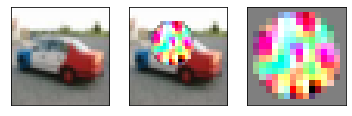

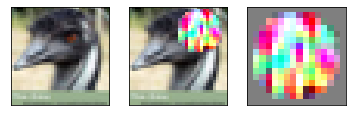

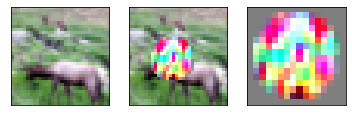

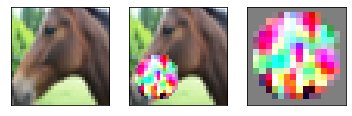

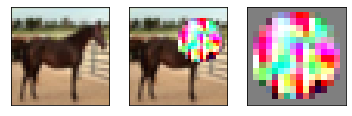

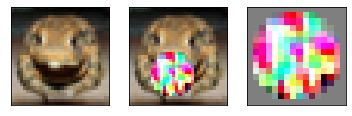

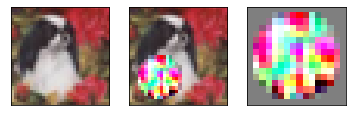

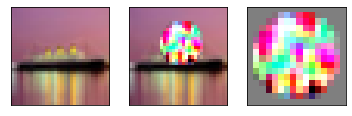

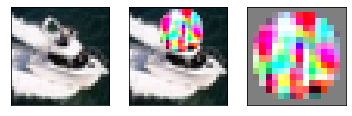

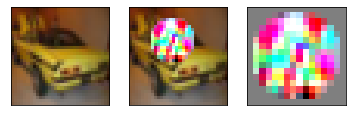

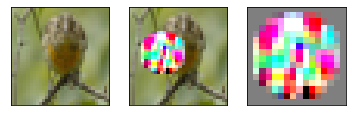

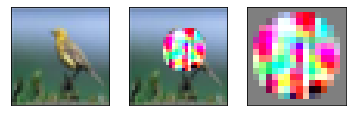

In [13]:
for xlist in adversary.result_list:
  if(xlist):
    show(xlist)

#MNIST

## Load Data

In [14]:
MEAN = [0.5]
STD = [0.5]
train_loader = torch.utils.data.DataLoader(
            datasets.MNIST(root = '/content/MNIST', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.Resize(28),
                               transforms.CenterCrop(28),
                               transforms.ToTensor(),
                               transforms.Normalize(MEAN, STD),
                           ])),batch_size=9, shuffle=True)



## Neural Network

In [15]:
class MnistCNN(nn.Module):
    def __init__(self):
        super(MnistCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, stride=2)
        self.bn = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 10, kernel_size=3, stride=3)
        self.bn2 = nn.BatchNorm2d(10)
        self.fc1 = nn.Linear(10 * 4 * 4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.bn(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(-1, 10 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
model = MnistCNN()

## Training

In [16]:
model.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.206
[1,   400] loss: 0.120
[1,   600] loss: 0.070
[1,   800] loss: 0.046
[1,  1000] loss: 0.040
[1,  1200] loss: 0.036
[1,  1400] loss: 0.031
[1,  1600] loss: 0.025
[1,  1800] loss: 0.025
[1,  2000] loss: 0.024
[1,  2200] loss: 0.020
[1,  2400] loss: 0.022
[1,  2600] loss: 0.021
[1,  2800] loss: 0.020
[1,  3000] loss: 0.018
[1,  3200] loss: 0.016
[1,  3400] loss: 0.015
[1,  3600] loss: 0.018
[1,  3800] loss: 0.015
[1,  4000] loss: 0.017
[1,  4200] loss: 0.016
[1,  4400] loss: 0.015
[1,  4600] loss: 0.018
[1,  4800] loss: 0.017
[1,  5000] loss: 0.014
[1,  5200] loss: 0.017
[1,  5400] loss: 0.014
[1,  5600] loss: 0.014
[1,  5800] loss: 0.012
[1,  6000] loss: 0.012
[1,  6200] loss: 0.014
[1,  6400] loss: 0.011
[1,  6600] loss: 0.013
[2,   200] loss: 0.011
[2,   400] loss: 0.012
[2,   600] loss: 0.011
[2,   800] loss: 0.011
[2,  1000] loss: 0.012
[2,  1200] loss: 0.012
[2,  1400] loss: 0.012
[2,  1600] loss: 0.011
[2,  1800] loss: 0.009
[2,  2000] loss: 0.011
[2,  2200] 

In [17]:
PATH = '/content/drive/MyDrive/TFG/MNIST/MNIST_net.pth'
torch.save(model.state_dict(), paths.MNIST_DIR)

## Attack

In [18]:
#One image 
batch_size = 1
dataloader = torch.utils.data.DataLoader(datasets.MNIST(root = '/content/MNIST', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(mean = MEAN, std = STD),
                           ])),  shuffle=True, batch_size = batch_size, num_workers = 2)

### Hyperparameters

In [19]:
PATH = paths.MNIST_DIR
SAVE_PATH = paths.MNIST_ADP_LOGS
MODEL_NAME = 'MNIST'

EPOCHS = 10
MAX_ROTATION = 22.5

TARGET_LABEL_IDX = 1

IMAGE_SHAPE = (28,28,1)

PATCH_SHAPE= (1, 1, 14, 14)

### Run Attack

In [20]:

model.load_state_dict(torch.load(PATH))

model.to(device)


adversary = AdversarialPatch(MODEL_NAME,PATCH_SHAPE, TARGET_LABEL_IDX, IMAGE_SHAPE, MAX_ROTATION, SAVE_PATH, MEAN, STD)
total_correct = 0

for epoch in range(1, EPOCHS):
  print('-'*20)
  print(f'Epoch:{epoch}')

  patch, adv, correct = adversary.train(dataloader, model, epoch)
  total_correct += correct
  


  inv_Trans= unNormalize(MEAN,STD)
  
  inv = torch.clamp(torch.from_numpy(patch[0]), -1, 1)
  inv = inv_Trans(inv)
  
  if(SAVE_PATH!=''):

    TV.utils.save_image(inv, join(SAVE_PATH, 'patch%d.png'%(epoch)))


  if (correct!=0):

    adversary.result_list[epoch-1].append(inv)
    

  else:
    
    adversary.result_list.append([])

  print("Patch attack success rate on trainset: {:.3f}%".format( 100 * total_correct/epoch))
  

 

#Scale patch shape to get more results

--------------------
Epoch:1
Loss 0.10555730760097504
torch.Size([1, 14, 14])
Patch attack success rate on trainset: 100.000%
--------------------
Epoch:2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss 0.10639343410730362
torch.Size([1, 14, 14])
Patch attack success rate on trainset: 100.000%
--------------------
Epoch:3
Loss -1
torch.Size([1, 14, 14])
Patch attack success rate on trainset: 66.667%
--------------------
Epoch:4
Loss -1
torch.Size([1, 14, 14])
Patch attack success rate on trainset: 75.000%
--------------------
Epoch:5
Loss -1
torch.Size([1, 14, 14])
Patch attack success rate on trainset: 60.000%
--------------------
Epoch:6
Loss -1
torch.Size([1, 14, 14])
Patch attack success rate on trainset: 66.667%
--------------------
Epoch:7
Loss -1
torch.Size([1, 14, 14])
Patch attack success rate on trainset: 57.143%
--------------------
Epoch:8
Loss -1
torch.Size([1, 14, 14])
Patch attack success rate on trainset: 50.000%
--------------------
Epoch:9
Loss -1
torch.Size([1, 14, 14])
Patch attack success rate on trainset: 44.444%


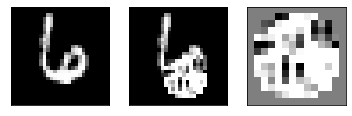

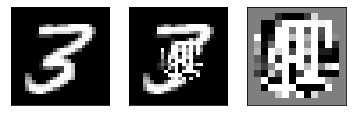

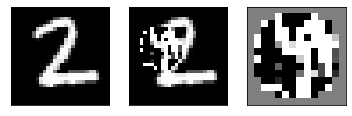

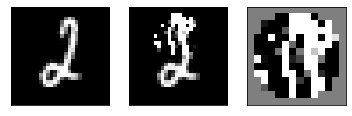

In [21]:
for xlist in adversary.result_list:
  if(xlist):
    show(xlist, gray=True)